# Agent environment with bitflipping actions, using DQN with HER

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{n^2}$ vector of the $Q$-values
    * The first index corresponds to integer $\geq 0$ representing the index of the bit being flipped
    * The second index corresponds to the goal
    * So $\text{model}(s)[a][g]$ will be the $Q$-value
 * Architecture: Simple MLP

## Goals
Here, the goal determines the reward function $R_g(s, a) = R(s, a, g)$. In our case, the goals are integer $0 \leq g \leq n-1$, where
$$
R_g(s, a) = \begin{cases}
1 & \text{If }d_\text{taxicab}(s', t) \leq g \\
0 & \text{Otherwise}
\end{cases}
$$
where $s',t$ are the new state (new bit sequence), target state (target bit sequence) respectively. Note that when $g=0$ it reduces to our usual reward function.

## Training method
DQN with HER (OpenAI paper)
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent), and a set of goals (of size 10) drawn uniformly for each agent. The agent will take action according to the first goal, and the rewards for the other randomly sampled goal(s) will be recorded. The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). We also fix the agent to use goal $g=0$. Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.


## Notes
**Optimal agent** For an optimal agent, $E[\text{steps}] = \frac{1}{2^n}\sum_{k=0}^n \dbinom{n}{k}k = \frac{n}{2}$. We expect the average number of steps to be close to $\frac{n}{2}$ if an optimal agent is chosen.

**Non-HER goal based agent** When HER is not used, we only record the experience for the agent according to the goal the agent is executing. This corresponds to num_goals=1 (do not record extra goals).

In [1]:
from src.environments.env_bit_sequence_flipping_goals import FlippingBitSequenceEnvWithGoals
from src.agents.agent_dqn_her import DQNHERAgent
from src.models.model_dqn_bitflipping_goals import BitFlippingDQNNetworkGoals
from src.models.buffer_bitflipping_goals import BufferBitflippingGoals

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0")

def train_DQN_HER_agent(n: int, device: torch.device,
    episodes: int=1000, num_explore_agents: int=16, num_valid_agents: int=1024,
    num_goals: int=10, batch_size: int=128,
    logging_frequency: int=200) -> None:

    # initialize environment, model and agent
    env = FlippingBitSequenceEnvWithGoals(n, device)
    model = BitFlippingDQNNetworkGoals(n)
    model.to(device)
    buffer = BufferBitflippingGoals(n)
    agent = DQNHERAgent(model=model, buffer=buffer, device=device,
                    action_space_size=n, goal_space_size=n)

    success_rates = []
    steps_to_success = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)
        # uniformly and randomly choose goals for the agent to act upon
        goals = torch.tensor(np.random.randint(0, n, (num_explore_agents, num_goals)), device=device, dtype=torch.int64)

        # let agent act for at most 50 steps
        for _ in range(50):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=True, goal=goals[:, 0]) # act with the randomly picked first goal for that agent
                next_state, reward, done, info = env.step(action, goals=goals)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                goal_rewards = info["goal_rewards"] # tensor indicating the reward for each goal
                prev_step_ongoing = ~prev_done

                for goal_idx in range(num_goals):
                    agent.remember(state[prev_step_ongoing, :].cpu().numpy(), action[prev_step_ongoing].cpu().numpy(),
                                goal_rewards[prev_step_ongoing, goal_idx].cpu().numpy(), next_state[prev_step_ongoing, :].cpu().numpy(), done[prev_step_ongoing].cpu().numpy(),
                                goals[prev_step_ongoing, goal_idx].cpu().numpy()) # record the goal specific rewards (HER)
                state = next_state
                if done.all():
                    break
        
        # replay to update Q network
        agent.replay(batch_size=batch_size)

        # now run the agent for at most 50 steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for step in range(50):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False, goal=0)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                if step == 0: # if by random chance the agent is already done in the first step, we need to handle this case
                    agent_steps_to_success[prev_done.cpu().numpy()] = 0
                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)

        if (e + 1) % logging_frequency == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(1, 2, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.show()

# Experiments (With HER)

$n=2$, optimal agent achieved as steps $\sim 1$

In [2]:
train_DQN_HER_agent(2, device=device)

Initialized FlippingBitSequenceEnvWithGoals with n = 2. Randomly picked target: tensor([1, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 20%|██        | 200/1000 [00:49<05:39,  2.36it/s]

Episode: 199/1000, Epsilon: 0.3669578217261671, Success rate: 1.00, Avg steps to success: 0.98


 29%|██▉       | 294/1000 [01:25<05:05,  2.31it/s]

$n=3$, optimal agent achieved as steps $\sim \frac{3}{2}$

Initialized FlippingBitSequenceEnv with n = 3. Randomly picked target: tensor([1, 0, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 102/1000 [00:07<00:43, 20.53it/s]

Episode: 99/1000, Epsilon: 0.6088145090359074, Success rate: 1.00, Avg steps to success: 1.50


 20%|██        | 203/1000 [00:13<00:57, 13.77it/s]

Episode: 199/1000, Epsilon: 0.36880183088056995, Success rate: 1.00, Avg steps to success: 1.50


 30%|███       | 304/1000 [00:18<00:27, 25.76it/s]

Episode: 299/1000, Epsilon: 0.22340924607110255, Success rate: 1.00, Avg steps to success: 1.55


 40%|████      | 403/1000 [00:21<00:21, 27.66it/s]

Episode: 399/1000, Epsilon: 0.1353347165085562, Success rate: 1.00, Avg steps to success: 1.50


 50%|█████     | 504/1000 [00:25<00:17, 28.60it/s]

Episode: 499/1000, Epsilon: 0.08198177029173696, Success rate: 1.00, Avg steps to success: 1.48


 60%|██████    | 603/1000 [00:28<00:17, 22.22it/s]

Episode: 599/1000, Epsilon: 0.04966213277390804, Success rate: 1.00, Avg steps to success: 1.47


 70%|███████   | 703/1000 [00:33<00:12, 23.86it/s]

Episode: 699/1000, Epsilon: 0.030083851847510768, Success rate: 1.00, Avg steps to success: 1.48


 80%|████████  | 804/1000 [00:36<00:06, 28.44it/s]

Episode: 799/1000, Epsilon: 0.018223908064988973, Success rate: 1.00, Avg steps to success: 1.51


 90%|█████████ | 904/1000 [00:40<00:03, 30.98it/s]

Episode: 899/1000, Epsilon: 0.011039504743095268, Success rate: 1.00, Avg steps to success: 1.46


100%|██████████| 1000/1000 [00:43<00:00, 22.99it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 1.48


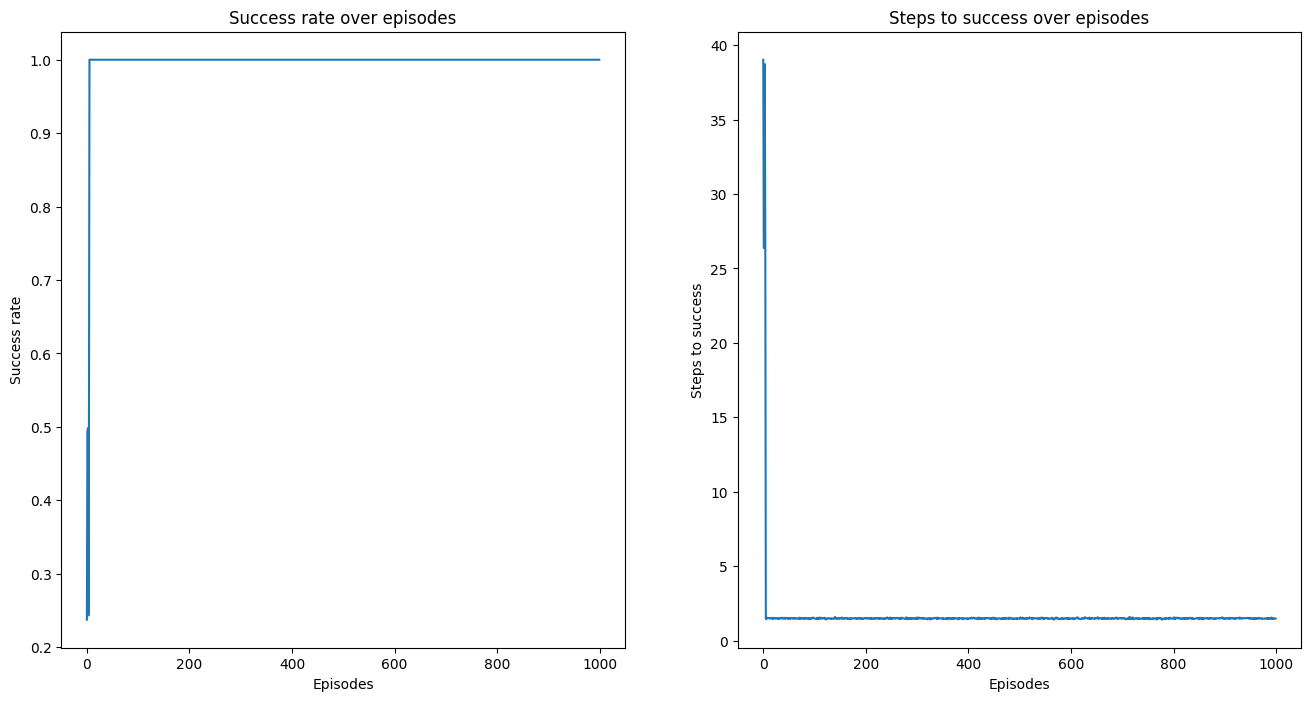

In [ ]:
train_DQN_HER_agent(3, device=device)

$n=6$, optimal agent achieved as steps $\sim 3$

Initialized FlippingBitSequenceEnv with n = 6. Randomly picked target: tensor([1, 1, 1, 0, 1, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 101/1000 [00:17<01:43,  8.69it/s]

Episode: 99/1000, Epsilon: 0.6057704364907278, Success rate: 1.00, Avg steps to success: 3.01


 20%|██        | 203/1000 [00:26<00:50, 15.85it/s]

Episode: 199/1000, Epsilon: 0.3669578217261671, Success rate: 1.00, Avg steps to success: 3.01


 30%|███       | 302/1000 [00:32<00:36, 19.02it/s]

Episode: 299/1000, Epsilon: 0.22229219984074702, Success rate: 1.00, Avg steps to success: 3.12


 40%|████      | 402/1000 [00:37<00:28, 20.63it/s]

Episode: 399/1000, Epsilon: 0.1346580429260134, Success rate: 1.00, Avg steps to success: 3.00


 50%|█████     | 504/1000 [00:42<00:22, 21.62it/s]

Episode: 499/1000, Epsilon: 0.08157186144027828, Success rate: 1.00, Avg steps to success: 3.01


 60%|██████    | 603/1000 [00:46<00:17, 22.36it/s]

Episode: 599/1000, Epsilon: 0.0494138221100385, Success rate: 1.00, Avg steps to success: 3.00


 70%|███████   | 702/1000 [00:51<00:13, 22.34it/s]

Episode: 699/1000, Epsilon: 0.029933432588273214, Success rate: 1.00, Avg steps to success: 3.06


 80%|████████  | 804/1000 [00:56<00:09, 21.45it/s]

Episode: 799/1000, Epsilon: 0.018132788524664028, Success rate: 1.00, Avg steps to success: 2.98


 90%|█████████ | 903/1000 [01:00<00:03, 24.68it/s]

Episode: 899/1000, Epsilon: 0.01098430721937979, Success rate: 1.00, Avg steps to success: 2.99


100%|██████████| 1000/1000 [01:04<00:00, 15.56it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 3.04


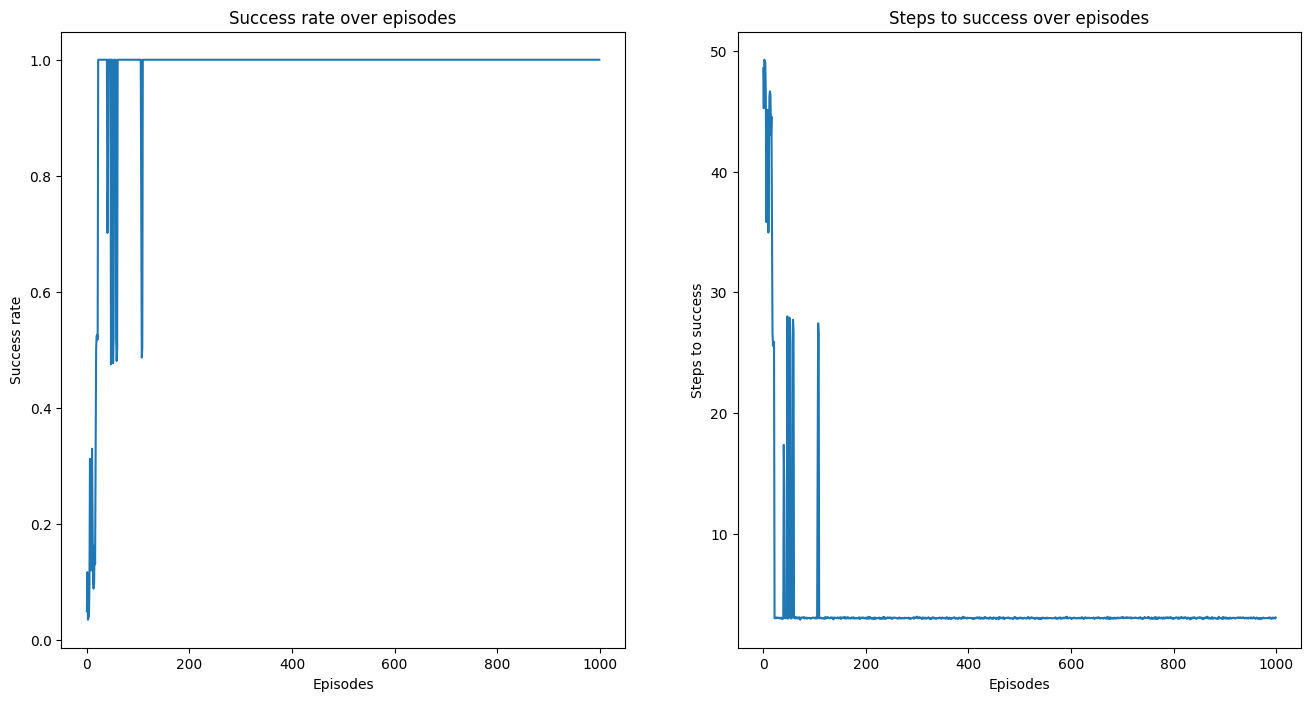

In [ ]:
train_DQN_HER_agent(6, device=device)

$n=15$, optimal agent achieved as steps $\sim 7.5$

Initialized FlippingBitSequenceEnv with n = 10. Randomly picked target: tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


 10%|█         | 101/1000 [00:22<03:06,  4.82it/s]

Episode: 99/1000, Epsilon: 0.6057704364907278, Success rate: 0.01, Avg steps to success: 50.71


 20%|██        | 200/1000 [00:43<02:43,  4.90it/s]

Episode: 199/1000, Epsilon: 0.3669578217261671, Success rate: 0.11, Avg steps to success: 45.88


 30%|███       | 302/1000 [00:55<00:52, 13.25it/s]

Episode: 299/1000, Epsilon: 0.22229219984074702, Success rate: 1.00, Avg steps to success: 5.03


 40%|████      | 402/1000 [01:02<00:42, 14.06it/s]

Episode: 399/1000, Epsilon: 0.1346580429260134, Success rate: 1.00, Avg steps to success: 5.02


 50%|█████     | 502/1000 [01:09<00:32, 15.17it/s]

Episode: 499/1000, Epsilon: 0.08157186144027828, Success rate: 1.00, Avg steps to success: 5.03


 60%|██████    | 602/1000 [01:16<00:34, 11.46it/s]

Episode: 599/1000, Epsilon: 0.0494138221100385, Success rate: 1.00, Avg steps to success: 5.02


 70%|███████   | 702/1000 [01:22<00:18, 16.17it/s]

Episode: 699/1000, Epsilon: 0.029933432588273214, Success rate: 1.00, Avg steps to success: 5.06


 80%|████████  | 802/1000 [01:28<00:11, 16.66it/s]

Episode: 799/1000, Epsilon: 0.018132788524664028, Success rate: 1.00, Avg steps to success: 5.09


 90%|█████████ | 902/1000 [01:34<00:05, 16.47it/s]

Episode: 899/1000, Epsilon: 0.01098430721937979, Success rate: 1.00, Avg steps to success: 5.03


100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]


Episode: 999/1000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 5.00


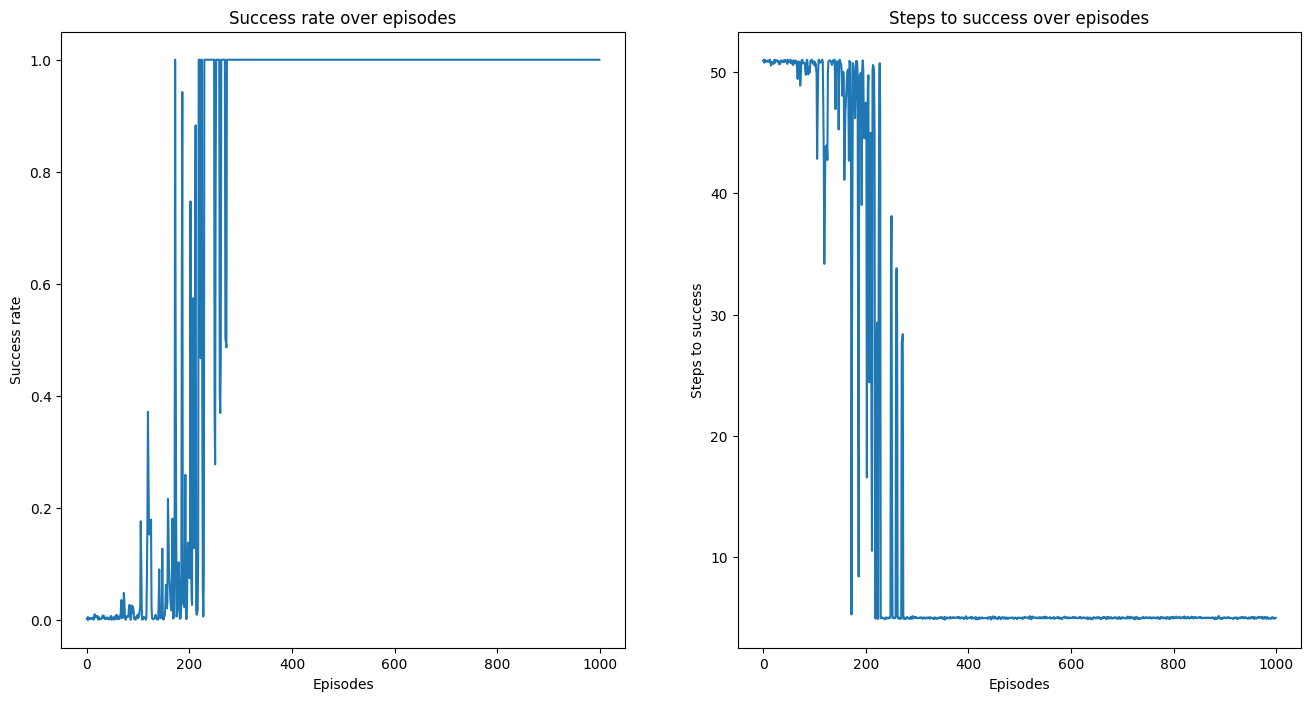

In [ ]:
train_DQN_HER_agent(15, device=device)

$n=15$. Given more training epochs, an optimal agent could be found (avg steps 7.5)

Initialized FlippingBitSequenceEnv with n = 15. Randomly picked target: tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


  2%|▎         | 100/4000 [00:23<13:51,  4.69it/s]

Episode: 99/4000, Epsilon: 0.6057704364907278, Success rate: 0.00, Avg steps to success: 51.00


  5%|▌         | 200/4000 [00:46<14:11,  4.46it/s]

Episode: 199/4000, Epsilon: 0.3669578217261671, Success rate: 0.00, Avg steps to success: 51.00


  8%|▊         | 300/4000 [01:08<14:02,  4.39it/s]

Episode: 299/4000, Epsilon: 0.22229219984074702, Success rate: 0.00, Avg steps to success: 50.95


 10%|█         | 400/4000 [01:32<14:11,  4.23it/s]

Episode: 399/4000, Epsilon: 0.1346580429260134, Success rate: 0.00, Avg steps to success: 51.00


 13%|█▎        | 501/4000 [01:56<12:27,  4.68it/s]

Episode: 499/4000, Epsilon: 0.08157186144027828, Success rate: 0.00, Avg steps to success: 51.00


 15%|█▌        | 600/4000 [02:20<13:54,  4.07it/s]

Episode: 599/4000, Epsilon: 0.0494138221100385, Success rate: 0.00, Avg steps to success: 51.00


 18%|█▊        | 700/4000 [02:45<13:40,  4.02it/s]

Episode: 699/4000, Epsilon: 0.029933432588273214, Success rate: 0.00, Avg steps to success: 51.00


 20%|██        | 800/4000 [03:10<12:57,  4.12it/s]

Episode: 799/4000, Epsilon: 0.018132788524664028, Success rate: 0.00, Avg steps to success: 50.95


 22%|██▎       | 900/4000 [03:35<12:34,  4.11it/s]

Episode: 899/4000, Epsilon: 0.01098430721937979, Success rate: 0.00, Avg steps to success: 51.00


 25%|██▌       | 1000/4000 [04:00<12:32,  3.99it/s]

Episode: 999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 28%|██▊       | 1100/4000 [04:25<12:47,  3.78it/s]

Episode: 1099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 50.95


 30%|███       | 1200/4000 [04:51<12:17,  3.80it/s]

Episode: 1199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 32%|███▎      | 1300/4000 [05:17<10:17,  4.37it/s]

Episode: 1299/4000, Epsilon: 0.01, Success rate: 0.21, Avg steps to success: 41.78


 35%|███▌      | 1400/4000 [05:41<10:15,  4.22it/s]

Episode: 1399/4000, Epsilon: 0.01, Success rate: 0.21, Avg steps to success: 41.75


 38%|███▊      | 1500/4000 [06:05<10:20,  4.03it/s]

Episode: 1499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 50.95


 40%|████      | 1600/4000 [06:31<12:24,  3.22it/s]

Episode: 1599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 43%|████▎     | 1701/4000 [06:58<07:33,  5.07it/s]

Episode: 1699/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.49


 45%|████▌     | 1801/4000 [07:10<03:45,  9.77it/s]

Episode: 1799/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.48


 48%|████▊     | 1901/4000 [07:22<04:21,  8.04it/s]

Episode: 1899/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.48


 50%|█████     | 2001/4000 [07:34<03:57,  8.40it/s]

Episode: 1999/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.56


 53%|█████▎    | 2101/4000 [07:46<03:47,  8.36it/s]

Episode: 2099/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.59


 55%|█████▌    | 2201/4000 [07:59<03:48,  7.88it/s]

Episode: 2199/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.51


 58%|█████▊    | 2301/4000 [08:11<03:26,  8.23it/s]

Episode: 2299/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.62


 60%|██████    | 2401/4000 [08:24<03:16,  8.16it/s]

Episode: 2399/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.42


 63%|██████▎   | 2501/4000 [08:36<03:01,  8.27it/s]

Episode: 2499/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.50


 65%|██████▌   | 2601/4000 [08:49<02:57,  7.89it/s]

Episode: 2599/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.56


 68%|██████▊   | 2701/4000 [09:02<02:47,  7.74it/s]

Episode: 2699/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.37


 70%|███████   | 2801/4000 [09:16<02:31,  7.91it/s]

Episode: 2799/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.51


 73%|███████▎  | 2901/4000 [09:29<02:41,  6.79it/s]

Episode: 2899/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.58


 75%|███████▌  | 3001/4000 [09:42<01:59,  8.39it/s]

Episode: 2999/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.58


 78%|███████▊  | 3101/4000 [09:55<01:52,  7.96it/s]

Episode: 3099/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.44


 80%|████████  | 3201/4000 [10:08<01:42,  7.76it/s]

Episode: 3199/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.57


 83%|████████▎ | 3301/4000 [10:21<01:28,  7.92it/s]

Episode: 3299/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.57


 85%|████████▌ | 3401/4000 [10:34<01:09,  8.56it/s]

Episode: 3399/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.41


 88%|████████▊ | 3501/4000 [10:46<00:58,  8.53it/s]

Episode: 3499/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.42


 90%|█████████ | 3601/4000 [10:57<00:46,  8.62it/s]

Episode: 3599/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.49


 93%|█████████▎| 3701/4000 [11:09<00:34,  8.73it/s]

Episode: 3699/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.50


 95%|█████████▌| 3801/4000 [11:21<00:25,  7.84it/s]

Episode: 3799/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.51


 98%|█████████▊| 3901/4000 [11:34<00:14,  7.00it/s]

Episode: 3899/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.46


100%|██████████| 4000/4000 [11:48<00:00,  5.65it/s]


Episode: 3999/4000, Epsilon: 0.01, Success rate: 1.00, Avg steps to success: 7.54


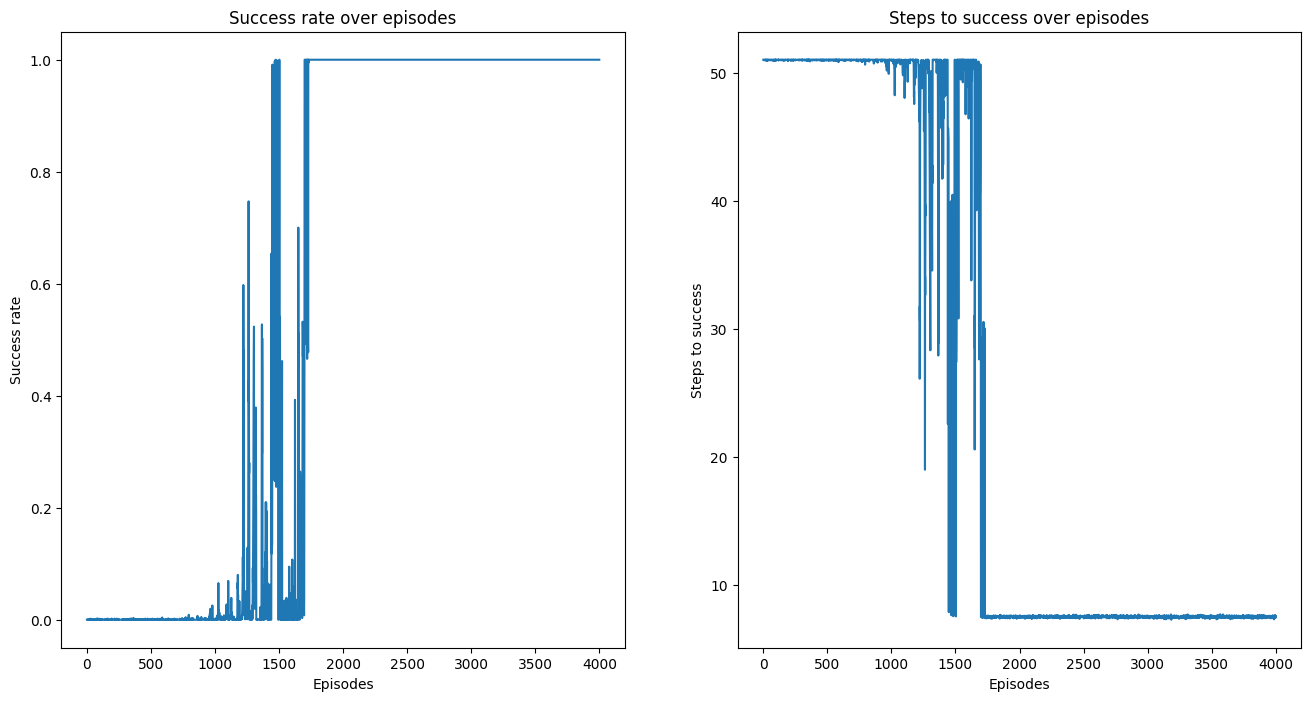

In [ ]:
train_DQN_HER_agent(15, device=device, episodes=4000, logging_frequency=800)

$n=30$ Now, with HER, our agent is able to find the optimal policy!

Initialized FlippingBitSequenceEnv with n = 30. Randomly picked target: tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


  1%|          | 100/10000 [00:24<37:26,  4.41it/s]

Episode: 99/10000, Epsilon: 0.6057704364907278, Success rate: 0.00, Avg steps to success: 51.00


  2%|▏         | 200/10000 [00:48<37:55,  4.31it/s]

Episode: 199/10000, Epsilon: 0.3669578217261671, Success rate: 0.00, Avg steps to success: 51.00


  3%|▎         | 300/10000 [01:11<37:04,  4.36it/s]

Episode: 299/10000, Epsilon: 0.22229219984074702, Success rate: 0.00, Avg steps to success: 51.00


  4%|▍         | 400/10000 [01:34<38:43,  4.13it/s]

Episode: 399/10000, Epsilon: 0.1346580429260134, Success rate: 0.00, Avg steps to success: 51.00


  5%|▌         | 500/10000 [01:58<35:51,  4.42it/s]

Episode: 499/10000, Epsilon: 0.08157186144027828, Success rate: 0.00, Avg steps to success: 51.00


  6%|▌         | 600/10000 [02:22<34:53,  4.49it/s]

Episode: 599/10000, Epsilon: 0.0494138221100385, Success rate: 0.00, Avg steps to success: 51.00


  7%|▋         | 701/10000 [02:46<33:55,  4.57it/s]

Episode: 699/10000, Epsilon: 0.029933432588273214, Success rate: 0.00, Avg steps to success: 51.00


  8%|▊         | 800/10000 [03:10<34:40,  4.42it/s]

Episode: 799/10000, Epsilon: 0.018132788524664028, Success rate: 0.00, Avg steps to success: 51.00


  9%|▉         | 900/10000 [03:34<36:02,  4.21it/s]

Episode: 899/10000, Epsilon: 0.01098430721937979, Success rate: 0.00, Avg steps to success: 51.00


 10%|█         | 1000/10000 [03:58<37:44,  3.97it/s]

Episode: 999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 11%|█         | 1100/10000 [04:23<37:51,  3.92it/s]

Episode: 1099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 12%|█▏        | 1200/10000 [04:49<38:22,  3.82it/s]

Episode: 1199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 13%|█▎        | 1300/10000 [05:14<37:36,  3.85it/s]

Episode: 1299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 14%|█▍        | 1400/10000 [05:40<38:52,  3.69it/s]

Episode: 1399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 15%|█▌        | 1500/10000 [06:06<36:25,  3.89it/s]

Episode: 1499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 16%|█▌        | 1600/10000 [06:33<37:48,  3.70it/s]

Episode: 1599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 17%|█▋        | 1700/10000 [06:59<38:19,  3.61it/s]

Episode: 1699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 18%|█▊        | 1800/10000 [07:27<37:41,  3.63it/s]

Episode: 1799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 19%|█▉        | 1900/10000 [07:54<35:12,  3.83it/s]

Episode: 1899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 20%|██        | 2000/10000 [08:22<40:23,  3.30it/s]

Episode: 1999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 21%|██        | 2100/10000 [08:49<37:17,  3.53it/s]

Episode: 2099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 22%|██▏       | 2200/10000 [09:15<29:33,  4.40it/s]

Episode: 2199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 23%|██▎       | 2300/10000 [09:39<33:56,  3.78it/s]

Episode: 2299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 24%|██▍       | 2400/10000 [10:06<34:09,  3.71it/s]

Episode: 2399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 25%|██▌       | 2500/10000 [10:34<37:55,  3.30it/s]

Episode: 2499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 26%|██▌       | 2600/10000 [10:59<29:18,  4.21it/s]

Episode: 2599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 27%|██▋       | 2700/10000 [11:28<34:36,  3.52it/s]

Episode: 2699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 28%|██▊       | 2800/10000 [11:57<34:06,  3.52it/s]

Episode: 2799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 29%|██▉       | 2900/10000 [12:26<34:11,  3.46it/s]

Episode: 2899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 30%|███       | 3000/10000 [12:56<35:45,  3.26it/s]

Episode: 2999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 31%|███       | 3100/10000 [13:27<33:35,  3.42it/s]

Episode: 3099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 32%|███▏      | 3200/10000 [13:59<30:57,  3.66it/s]

Episode: 3199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 33%|███▎      | 3300/10000 [14:26<30:22,  3.68it/s]

Episode: 3299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 34%|███▍      | 3400/10000 [14:55<34:06,  3.22it/s]

Episode: 3399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 35%|███▌      | 3500/10000 [15:25<34:08,  3.17it/s]

Episode: 3499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 36%|███▌      | 3600/10000 [15:57<33:19,  3.20it/s]

Episode: 3599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 37%|███▋      | 3700/10000 [16:28<32:56,  3.19it/s]

Episode: 3699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 38%|███▊      | 3800/10000 [17:01<36:06,  2.86it/s]

Episode: 3799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 39%|███▉      | 3900/10000 [17:32<32:32,  3.12it/s]

Episode: 3899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 40%|████      | 4000/10000 [18:05<33:00,  3.03it/s]

Episode: 3999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 41%|████      | 4100/10000 [18:42<34:43,  2.83it/s]

Episode: 4099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 42%|████▏     | 4200/10000 [19:19<38:55,  2.48it/s]

Episode: 4199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 43%|████▎     | 4300/10000 [19:58<38:18,  2.48it/s]

Episode: 4299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 44%|████▍     | 4400/10000 [20:36<34:31,  2.70it/s]

Episode: 4399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 45%|████▌     | 4500/10000 [21:13<35:43,  2.57it/s]

Episode: 4499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 46%|████▌     | 4600/10000 [21:52<34:04,  2.64it/s]

Episode: 4599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 47%|████▋     | 4700/10000 [22:30<33:50,  2.61it/s]

Episode: 4699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 48%|████▊     | 4800/10000 [23:09<33:35,  2.58it/s]

Episode: 4799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 49%|████▉     | 4900/10000 [23:50<34:40,  2.45it/s]

Episode: 4899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 50%|█████     | 5000/10000 [24:30<31:46,  2.62it/s]

Episode: 4999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 51%|█████     | 5100/10000 [25:14<31:45,  2.57it/s]

Episode: 5099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 52%|█████▏    | 5200/10000 [26:03<42:33,  1.88it/s]

Episode: 5199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 53%|█████▎    | 5300/10000 [26:43<28:14,  2.77it/s]

Episode: 5299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 54%|█████▍    | 5400/10000 [27:24<31:40,  2.42it/s]

Episode: 5399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 55%|█████▌    | 5500/10000 [28:05<31:04,  2.41it/s]

Episode: 5499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 56%|█████▌    | 5600/10000 [28:46<26:48,  2.74it/s]

Episode: 5599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 57%|█████▋    | 5700/10000 [29:23<27:12,  2.63it/s]

Episode: 5699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 58%|█████▊    | 5800/10000 [30:01<28:02,  2.50it/s]

Episode: 5799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 59%|█████▉    | 5900/10000 [30:40<26:18,  2.60it/s]

Episode: 5899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 60%|██████    | 6000/10000 [31:18<26:08,  2.55it/s]

Episode: 5999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 61%|██████    | 6100/10000 [31:58<25:35,  2.54it/s]

Episode: 6099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 62%|██████▏   | 6200/10000 [32:37<25:21,  2.50it/s]

Episode: 6199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 63%|██████▎   | 6300/10000 [33:18<24:58,  2.47it/s]

Episode: 6299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 64%|██████▍   | 6400/10000 [34:00<25:31,  2.35it/s]

Episode: 6399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 65%|██████▌   | 6500/10000 [34:41<24:10,  2.41it/s]

Episode: 6499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 66%|██████▌   | 6600/10000 [35:23<23:17,  2.43it/s]

Episode: 6599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 67%|██████▋   | 6700/10000 [36:05<22:56,  2.40it/s]

Episode: 6699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 68%|██████▊   | 6800/10000 [36:48<23:09,  2.30it/s]

Episode: 6799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 69%|██████▉   | 6900/10000 [37:30<22:24,  2.31it/s]

Episode: 6899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 70%|███████   | 7000/10000 [38:13<21:33,  2.32it/s]

Episode: 6999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 71%|███████   | 7100/10000 [38:57<21:26,  2.25it/s]

Episode: 7099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 72%|███████▏  | 7200/10000 [39:40<20:47,  2.24it/s]

Episode: 7199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 73%|███████▎  | 7300/10000 [40:25<19:58,  2.25it/s]

Episode: 7299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 74%|███████▍  | 7400/10000 [41:10<19:52,  2.18it/s]

Episode: 7399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 75%|███████▌  | 7500/10000 [41:56<19:12,  2.17it/s]

Episode: 7499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 76%|███████▌  | 7600/10000 [42:41<18:22,  2.18it/s]

Episode: 7599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 77%|███████▋  | 7700/10000 [43:27<17:44,  2.16it/s]

Episode: 7699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 78%|███████▊  | 7800/10000 [44:14<17:32,  2.09it/s]

Episode: 7799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 79%|███████▉  | 7900/10000 [45:01<16:37,  2.11it/s]

Episode: 7899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 80%|████████  | 8000/10000 [45:48<15:51,  2.10it/s]

Episode: 7999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 81%|████████  | 8100/10000 [46:37<16:13,  1.95it/s]

Episode: 8099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 82%|████████▏ | 8200/10000 [47:26<14:36,  2.05it/s]

Episode: 8199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 83%|████████▎ | 8300/10000 [48:15<13:41,  2.07it/s]

Episode: 8299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 84%|████████▍ | 8400/10000 [49:04<13:21,  2.00it/s]

Episode: 8399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 85%|████████▌ | 8500/10000 [49:54<12:32,  1.99it/s]

Episode: 8499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 86%|████████▌ | 8600/10000 [50:45<11:47,  1.98it/s]

Episode: 8599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 87%|████████▋ | 8700/10000 [51:36<10:59,  1.97it/s]

Episode: 8699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 88%|████████▊ | 8800/10000 [52:27<10:08,  1.97it/s]

Episode: 8799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 89%|████████▉ | 8900/10000 [53:19<09:41,  1.89it/s]

Episode: 8899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 90%|█████████ | 9000/10000 [54:11<08:43,  1.91it/s]

Episode: 8999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 91%|█████████ | 9100/10000 [55:04<07:52,  1.91it/s]

Episode: 9099/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 92%|█████████▏| 9200/10000 [55:57<07:04,  1.88it/s]

Episode: 9199/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 93%|█████████▎| 9300/10000 [56:50<06:11,  1.89it/s]

Episode: 9299/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 94%|█████████▍| 9400/10000 [57:43<05:22,  1.86it/s]

Episode: 9399/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 95%|█████████▌| 9500/10000 [58:37<04:28,  1.86it/s]

Episode: 9499/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 96%|█████████▌| 9600/10000 [59:32<03:39,  1.82it/s]

Episode: 9599/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 97%|█████████▋| 9700/10000 [1:00:27<02:45,  1.82it/s]

Episode: 9699/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 98%|█████████▊| 9800/10000 [1:01:23<01:52,  1.77it/s]

Episode: 9799/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


 99%|█████████▉| 9900/10000 [1:02:19<00:56,  1.78it/s]

Episode: 9899/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


100%|██████████| 10000/10000 [1:03:15<00:00,  2.63it/s]

Episode: 9999/10000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00


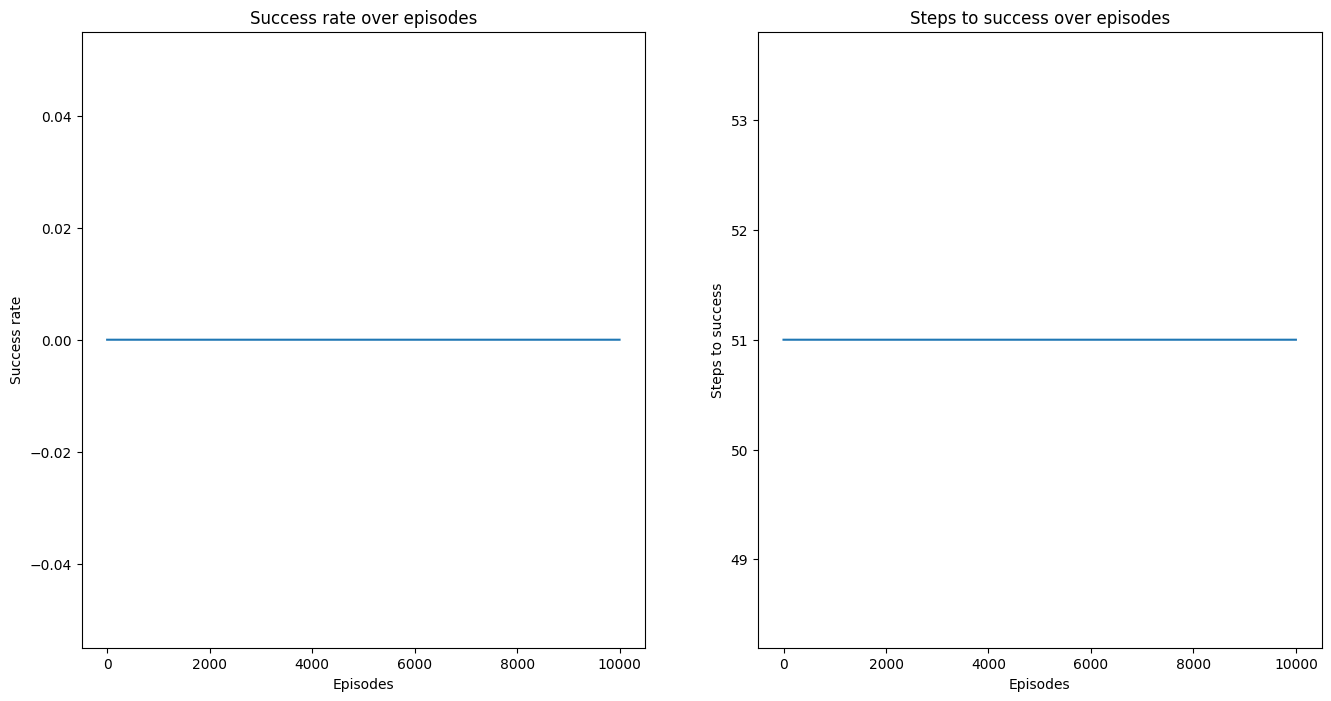

In [ ]:
train_DQN_HER_agent(30, device=device, episodes=10000, logging_frequency=2000)

$n=50$ Testing large $n$ with HER.

In [ ]:
train_DQN_HER_agent(50, device=device, episodes=10000, logging_frequency=2000)

# Experiements (DQN with goals, but no HER)

Here we only record the rewards of the goals where the exploration agent has acted with (meaning no HER). As mentioned before, this corresponds to $\text{num\_goals} = 1$

In [ ]:
train_DQN_HER_agent(30, device=device, episodes=10000, logging_frequency=2000)

In [ ]:
train_DQN_HER_agent(50, device=device, episodes=10000, logging_frequency=2000)